In [2]:
import os
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
# Dossiers
base_path = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented"

images_dir = os.path.join(base_path, "images")
masks_dir = os.path.join(base_path, "masks")

# Lister et trier tous les fichiers .jpg
image_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
mask_paths = sorted(glob(os.path.join(masks_dir, "*.jpg")))

print(f"Nombre d'images : {len(image_paths)}")
print(f"Nombre de masques : {len(mask_paths)}")

Nombre d'images : 5108
Nombre de masques : 5108


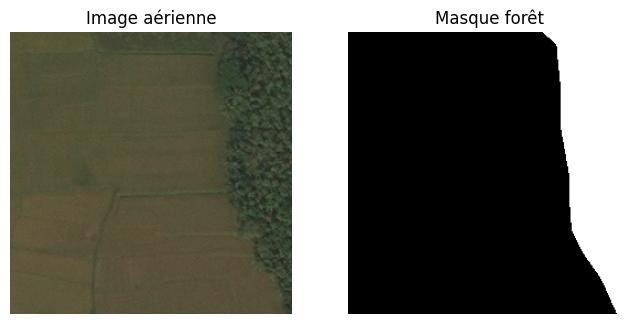

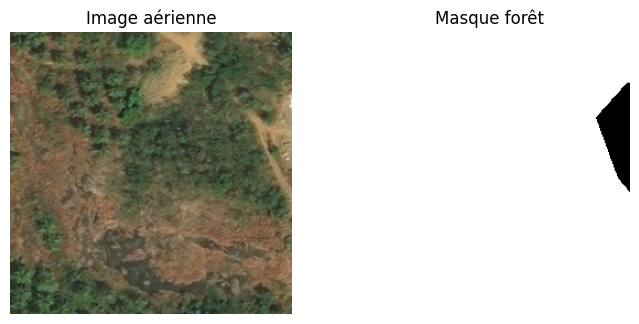

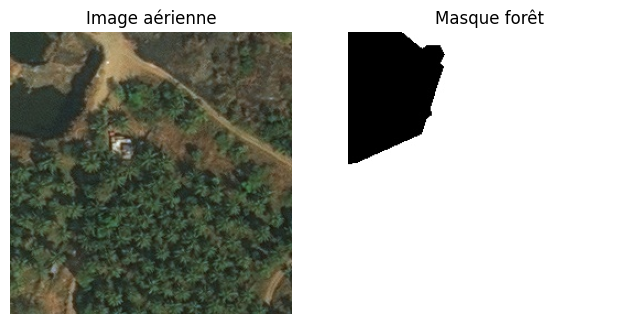

In [4]:
# Choisir 3 exemples aléatoires
for i in [0, 10, 20]:
    img = cv2.imread(image_paths[i])                 # Lire image (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convertir en RGB
    mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)  # Masque en niveaux de gris
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Image aérienne")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Masque forêt")
    plt.axis("off")
    
    plt.show()


In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = img / 255.0                         
    return img

def preprocess_mask(mask_path, threshold=127):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask > threshold, 1, 0)    
    mask = np.expand_dims(mask, axis=-1)      
    return mask

In [6]:

# 70% train
train_size = 0.7
# 20% val
val_size = 0.2 / (1 - train_size)  # proportion de la partie restante (30%)

# Split train / temp (train 70%, temp 30%)
train_img, temp_img, train_mask, temp_mask = train_test_split(
    image_paths, mask_paths, test_size=1-train_size, random_state=42
)

# Split temp en validation et test (20% et 10% du total)
val_img, test_img, val_mask, test_mask = train_test_split(
    temp_img, temp_mask, test_size=1-(val_size), random_state=42
)

print(f"Train: {len(train_img)} images")
print(f"Validation: {len(val_img)} images")
print(f"Test: {len(test_img)} images")

Train: 3575 images
Validation: 1021 images
Test: 512 images


In [7]:
from tensorflow.keras.utils import Sequence
import albumentations as A  # bibliothèque pour augmentation
import random

# --- Définir les augmentations ---
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),         # Flip horizontal aléatoire
    A.VerticalFlip(p=0.5),           # Flip vertical aléatoire
    A.Rotate(limit=30, p=0.5),       # Rotation aléatoire jusqu'à ±30°
    A.RandomBrightnessContrast(p=0.3) # Ajustement de luminosité/contraste
])

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_img_paths = [self.image_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]
        
        X = []
        Y = []
        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            img = preprocess_image(img_path)
            mask = preprocess_mask(mask_path)
            
            # --- Data augmentation ---
            if self.augment:
                augmented = augmentation(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            
            X.append(img)
            Y.append(mask)
        
        return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# --- Création des générateurs ---
batch_size = 16

train_gen = DataGenerator(train_img, train_mask, batch_size=batch_size, augment=True)
val_gen = DataGenerator(val_img, val_mask, batch_size=batch_size, augment=False)
test_gen = DataGenerator(test_img, test_mask, batch_size=batch_size, shuffle=False, augment=False)


In [8]:
X_batch, Y_batch = train_gen[0]
print("Shape X_batch :", X_batch.shape)
print("Shape Y_batch :", Y_batch.shape)

Shape X_batch : (16, 256, 256, 3)
Shape Y_batch : (16, 256, 256, 1)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def HRNet(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # --- Stem ---
    x = conv_block(inputs, 64, 3, 2)
    x = conv_block(x, 64, 3, 2)

    # --- Stage 1 ---
    x1 = conv_block(x, 64)
    x1 = conv_block(x1, 64)

    # --- Stage 2 (multi-resolution) ---
    x2_1 = conv_block(x1, 64)
    x2_2 = conv_block(layers.AveragePooling2D(pool_size=2)(x1), 128)

    # --- Fuse Stage 2 ---
    x2_2_up = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x2_2)
    x2_fused = layers.Concatenate()([x2_1, x2_2_up])

    # --- Stage 3 (multi-resolution) ---
    x3_1 = conv_block(x2_fused, 64)
    x3_2 = conv_block(layers.AveragePooling2D(pool_size=2)(x2_fused), 128)
    x3_3 = conv_block(layers.AveragePooling2D(pool_size=4)(x2_fused), 256)

    # --- Fuse Stage 3 ---
    x3_2_up = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x3_2)
    x3_3_up = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x3_3)
    x3_fused = layers.Concatenate()([x3_1, x3_2_up, x3_3_up])

    # --- Decoder ---
    x = conv_block(x3_fused, 256)
    x = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    # --- Output ---
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = layers.Conv2D(num_classes, 1, padding='same', activation=activation)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# --- Exemple d'utilisation ---
model = HRNet(input_shape=(256, 256, 3), num_classes=1)
model.summary()


I0000 00:00:1761146218.152557     906 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761146218.153326     906 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ average_pooling2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Concatenate)       │ 192)              │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 32, 32,    │          0 │ concatenate[0][0

 Total params: 2,035,265 (7.76 MB)

 Trainable params: 2,032,961 (7.76 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [10]:
from tensorflow.keras import backend as K

# Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# IoU
def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Compilation améliorée
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', dice_coefficient, iou_metric]
)


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_model_HRNet.h5", monitor='val_loss', save_best_only=True, verbose=1)

# Entraînement
epochs = 30
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7596 - dice_coefficient: 0.7178 - iou_metric: 0.5610 - loss: 0.5232
Epoch 1: val_loss improved from inf to 0.75598, saving model to best_model_HRNet.h5
224/224 ━━━━━━━━━━━━━━━━━━━━ 110s 491ms/step - accuracy: 0.7596 - dice_coefficient: 0.7178 - iou_metric: 0.5610 - loss: 0.5232 - val_accuracy: 0.4349 - val_dice_coefficient: 0.4715 - val_iou_metric: 0.3089 - val_loss: 0.7560 - learning_rate: 1.0000e-04
Epoch 2/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7769 - dice_coefficient: 0.7299 - iou_metric: 0.5763 - loss: 0.4844
Epoch 2: val_loss improved from 0.75598 to 0.69835, saving model to best_model_HRNet.h5
224/224 ━━━━━━━━━━━━━━━━━━━━ 88s 393ms/step - accuracy: 0.7769 - dice_coefficient: 0.7299 - iou_metric: 0.5763 - loss: 0.4844 - val_accuracy: 0.5788 - val_dice_coefficient: 0.5339 - val_iou_metric: 0.3649 - val_loss: 0.6984 - learning_rate: 1.0000e-04
Epoch 3/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/st

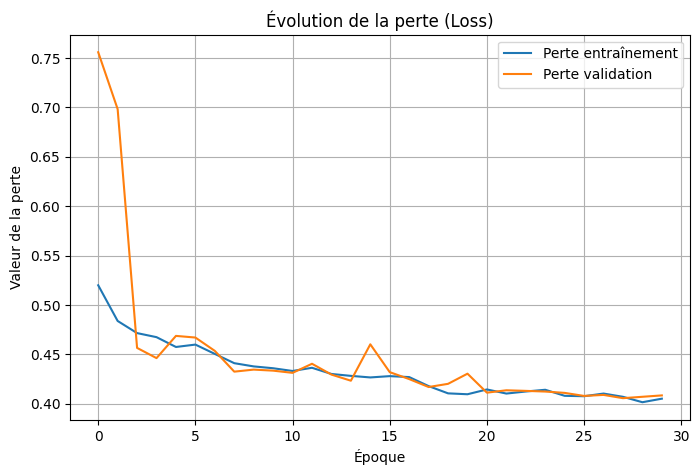

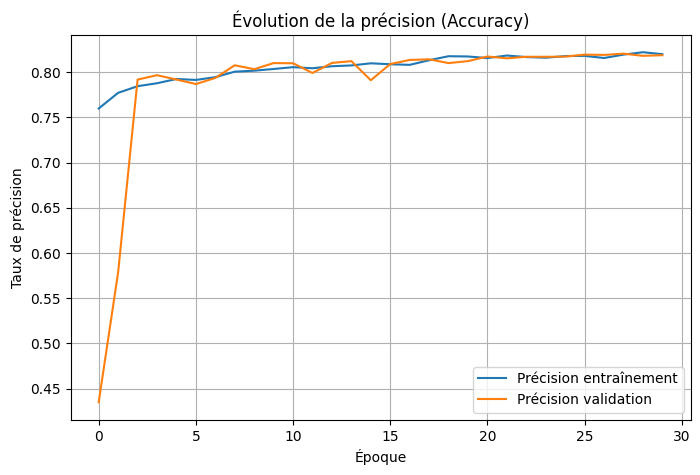

In [14]:
import matplotlib.pyplot as plt

# --- Courbes de perte (Loss) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Évolution de la perte (Loss)")
plt.xlabel("Époque")
plt.ylabel("Valeur de la perte")
plt.legend()
plt.grid(True)
plt.show()

# --- Courbes de précision (Accuracy) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title("Évolution de la précision (Accuracy)")
plt.xlabel("Époque")
plt.ylabel("Taux de précision")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


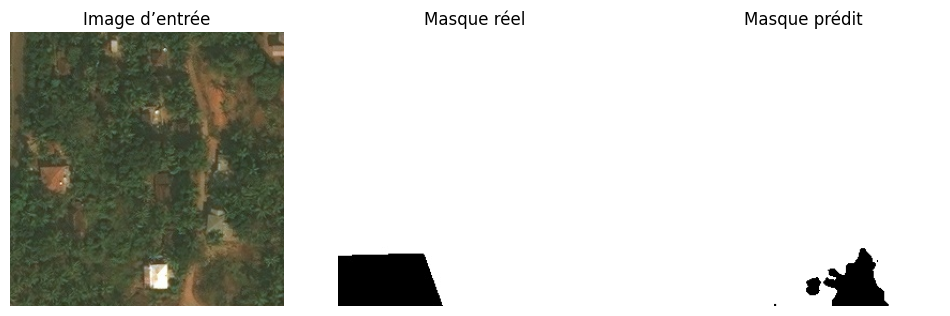

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


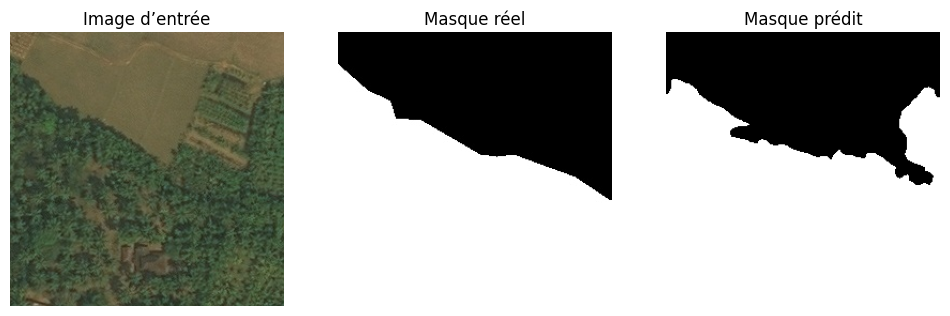

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


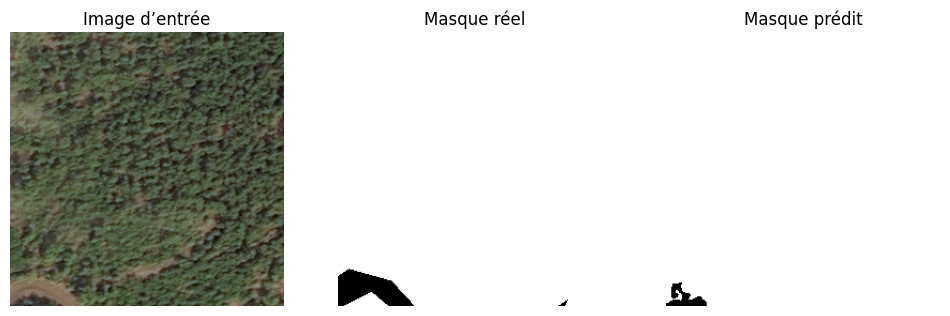

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Fonction pour prédire et afficher ---
def visualize_predictions(model, image_paths, mask_paths, num_samples=3):
    """
    Affiche quelques images avec leur masque réel et le masque prédit par le modèle.
    """
    for i in range(num_samples):
        # Sélectionner une image et son masque
        img_path = image_paths[i]
        mask_path = mask_paths[i]

        # Charger et prétraiter l’image
        img = np.array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = np.array(load_img(mask_path, target_size=(256, 256), color_mode="grayscale")) / 255.0

        # Ajouter une dimension batch pour la prédiction
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Seuil pour convertir en masque binaire (0 ou 1)
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Affichage côte à côte
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image d’entrée")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")

        plt.show()

# --- Utilisation avec ton dataset de test ---
visualize_predictions(model, test_img, test_mask, num_samples=3)


In [19]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

# ==========================
# 🔹 Fonctions de métriques
# ==========================
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# ==========================
# 🔹 Évaluation sur le test set
# ==========================
# Récupération du premier batch test
X_test, Y_test = test_gen[0]
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred > 0.5).astype(np.float32)

# ==========================
# 🔹 Calcul des métriques
# ==========================
iou = iou_metric(Y_test, Y_pred_bin)
dice = dice_coef(Y_test, Y_pred_bin)
precision = precision_score(Y_test.flatten(), Y_pred_bin.flatten())
recall = recall_score(Y_test.flatten(), Y_pred_bin.flatten())

# Évaluation pour récupérer la loss
eval_result = model.evaluate(X_test, Y_test, verbose=0)
loss_value = eval_result[0] 

# ==========================
# 🔹 Affichage des résultats
# ==========================
print(f"IoU (Intersection over Union): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Loss: {loss_value:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
IoU (Intersection over Union): 0.8201
Dice Coefficient: 0.9012
Precision: 0.8760
Recall: 0.9278
Loss: 0.3348
